In [1]:
import numpy as np
import tensorflow as tf
from utils import *
import scipy.misc

/Users/mdeblaauw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load in image

In [30]:
content = get_img('../../project-style/images/content.jpeg')
content_image = np.array([content])

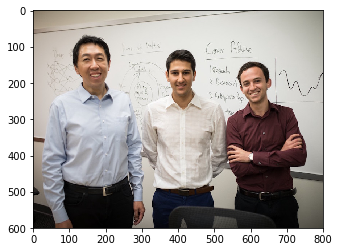

In [31]:
imshow(content)

# Graph functions

In [3]:
WEIGHTS_INIT_STDEV = .1

In [4]:
def _conv_layer(net, num_filters, filter_size, strides, relu=True):
    weights_init = _conv_init_vars(net, num_filters, filter_size)
    strides_shape = [1, strides, strides, 1]
    net = tf.nn.conv2d(net, weights_init, strides_shape, padding='SAME')
    net = _instance_norm(net)
    if relu:
        net = tf.nn.relu(net)

    return net

In [5]:
def _instance_norm(net, train=True):
    batch, rows, cols, channels = [i.value for i in net.get_shape()]
    var_shape = [channels]
    mu, sigma_sq = tf.nn.moments(net, [1,2], keep_dims=True)
    shift = tf.Variable(tf.zeros(var_shape))
    scale = tf.Variable(tf.ones(var_shape))
    epsilon = 1e-3
    normalized = (net-mu)/(sigma_sq + epsilon)**(.5)
    return scale * normalized + shift

In [6]:
def _conv_tranpose_layer(net, num_filters, filter_size, strides):
    weights_init = _conv_init_vars(net, num_filters, filter_size, transpose=True)

    batch_size, rows, cols, in_channels = [i.value for i in net.get_shape()]
    new_rows, new_cols = int(rows * strides), int(cols * strides)
    # new_shape = #tf.pack([tf.shape(net)[0], new_rows, new_cols, num_filters])

    new_shape = [batch_size, new_rows, new_cols, num_filters]
    tf_shape = tf.stack(new_shape)
    strides_shape = [1,strides,strides,1]

    net = tf.nn.conv2d_transpose(net, weights_init, tf_shape, strides_shape, padding='SAME')
    net = _instance_norm(net)
    return tf.nn.relu(net)

In [7]:
def _conv_init_vars(net, out_channels, filter_size, transpose=False):
    _, rows, cols, in_channels = [i.value for i in net.get_shape()]
    if not transpose:
        weights_shape = [filter_size, filter_size, in_channels, out_channels]
    else:
        weights_shape = [filter_size, filter_size, out_channels, in_channels]

    weights_init = tf.Variable(tf.truncated_normal(weights_shape, stddev=WEIGHTS_INIT_STDEV, seed=1), dtype=tf.float32)
    return weights_init

In [8]:
def _residual_block(net, filter_size=3):
    tmp = _conv_layer(net, 128, filter_size, 1)
    return net + _conv_layer(tmp, 128, filter_size, 1, relu=False)

In [9]:
def image_maker(image):
    conv1 = _conv_layer(image, 32, 9, 1)
    conv2 = _conv_layer(conv1, 64, 3, 2)
    conv3 = _conv_layer(conv2, 128, 3, 2)
    resid1 = _residual_block(conv3, 3)
    resid2 = _residual_block(resid1, 3)
    resid3 = _residual_block(resid2, 3)
    resid4 = _residual_block(resid3, 3)
    resid5 = _residual_block(resid4, 3)
    conv_t1 = _conv_tranpose_layer(resid5, 64, 3, 2)
    conv_t2 = _conv_tranpose_layer(conv_t1, 32, 3, 2)
    conv_t3 = _conv_layer(conv_t2, 3, 9, 1, relu=False)
    preds = tf.nn.tanh(conv_t3) * 150 + 255./2
    return preds

# Generate image

In [34]:
preds = content_image
with tf.Graph().as_default(), tf.Session() as sess:
    img_placeholder = tf.placeholder(tf.float32, shape = content_image.shape, name='img_placeholder')
    
    generated_image = image_maker(img_placeholder/255.0)
    saver = tf.train.Saver()
    saver.restore(sess, '../../weights/weights-08082018/model1.ckpt')
    
    preds = sess.run(generated_image, feed_dict = {img_placeholder: content_image})
    
    preds_reshape = np.reshape(preds, (preds.shape[1], preds.shape[2], preds.shape[3]))
    save_img('../../test5.jpg', preds_reshape)

INFO:tensorflow:Restoring parameters from ../../weights/weights-08082018/model1.ckpt


In [12]:
from matplotlib.pyplot import imshow
%matplotlib inline

In [16]:
preds_reshape.shape

(600, 800, 3)

In [19]:
aa = preds_reshape.astype(int)

In [21]:
aa.shape

(600, 800, 3)

TypeError: Invalid dimensions for image data

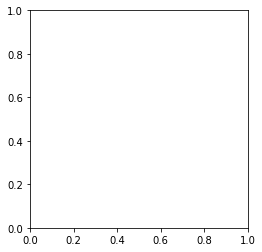

In [23]:
imshow(preds_reshape.shape)